**Import Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import ast
import re
import nltk
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
from IPython.core.display import HTML
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('stopwords')

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


**Loading Data**

Laoding CSV file from download link and save it to a dataframe

In [0]:
job_csv = "https://drive.google.com/uc?export=download&id=1cnUY_KwtTfY09NcSgg_h0BX8cURAf1CH"
job_dataframe = pd.read_csv(job_csv)

**Data**
As ststed from the task, only JobTitle and JobFunctions are needed for the model.
The model is Multi-label calssifier.

In [3]:
job_dataframe = job_dataframe.ix[:,(1,2)]
print (job_dataframe)

                                                   title                                        jobFunction
0                               Full Stack PHP Developer  ['Engineering - Telecom/Technology', 'IT/Softw...
1                CISCO Collaboration Specialist Engineer  ['Installation/Maintenance/Repair', 'IT/Softwa...
2                          Senior Back End-PHP Developer  ['Engineering - Telecom/Technology', 'IT/Softw...
3                                            UX Designer  ['Creative/Design/Art', 'IT/Software Developme...
4                                    Java Technical Lead  ['Engineering - Telecom/Technology', 'IT/Softw...
...                                                  ...                                                ...
10865                                     Odoo Developer  ['IT/Software Development', 'Engineering - Tel...
10866                  Senior PHP Developer - Alexandria  ['Engineering - Telecom/Technology', 'IT/Softw...
10867  Sales & Account Manag

# **Data Cleaning**

## **Cleaning Job Functions**

Remobing "/" "-" " " as they get the MultiLabelBinarizer classifier messy. and making sure every job title has at least on job function.

In [0]:
def cleanjobfun(jobfuns):
  jobfun_cleaned = []
  for jobfun in jobfuns:
    for word in jobfun:
      word = word.replace("/" , "")
      word = word.replace("-" , "")
      word = word.replace(" " , "")      
      if(word !='nan'):
        jobfun_cleaned.append(word)
  return list(dict.fromkeys(jobfun_cleaned)) 


In [5]:
# seprate the string of each row into lists of each job function
job_dataframe['jobFunction'] = job_dataframe['jobFunction'].apply(ast.literal_eval).apply(np.sort)

# grouping job functions for same title into list of lists
job_dataframe_cleaned = job_dataframe.groupby('title').jobFunction.apply(list).reset_index()

# cleanjobFunction
job_dataframe_cleaned['jobFunction'] = job_dataframe_cleaned['jobFunction'].apply(cleanjobfun)

# remove any empty lists(data with missing job functions)
job_dataframe_cleaned = job_dataframe_cleaned[job_dataframe_cleaned['jobFunction'].map(lambda d: len(d)) > 0].reset_index()
job_dataframe_cleaned = job_dataframe_cleaned[job_dataframe_cleaned['title'].map(lambda d: len(d)) > 0].reset_index()

job_dataframe_cleaned

,level_0,index,title,jobFunction
0,0,0,.NET Backend Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
1,1,1,.NET Core Developer - Senior\Team Lead,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
2,2,2,.NET Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
3,3,3,.NET Full Stack Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
4,4,4,.NET Full Stack Web Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
...,...,...,...,...
3156,3156,3225,iOS Mobile Application Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
3157,3157,3226,iOS Software Engineer,"[EngineeringTelecomTechnology, ITSoftwareDevel..."
3158,3158,3227,معلم لغة عربية,[EducationTeaching]
3159,3159,3228,مندوب مبيعات - خارجي,[SalesRetail]


# **Multi-Label Classifier**

using MultiLabelBinarizer to seperate Job Functions into Classes (0 if not found and 1 if found)

In [6]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(job_dataframe_cleaned['jobFunction'])
y = multilabel_binarizer.transform(job_dataframe_cleaned['jobFunction'])
for idx, job in enumerate(multilabel_binarizer.classes_):
  job_dataframe_cleaned[job] = y[:,idx]

#### remove created index by binarizer
job_dataframe_cleaned = job_dataframe_cleaned.ix[:,2:]
job_dataframe_cleaned

,title,jobFunction,AccountingFinance,Administration,AnalystResearch,Banking,BusinessDevelopment,CLevelExecutiveGMDirector,CreativeDesignArt,CustomerServiceSupport,EducationTeaching,EngineeringConstructionCivilArchitecture,EngineeringMechanicalElectrical,EngineeringOil&GasEnergy,EngineeringOther,EngineeringTelecomTechnology,Fashion,HospitalityHotelsFoodServices,HumanResources,ITSoftwareDevelopment,InstallationMaintenanceRepair,Legal,LogisticsSupplyChain,ManufacturingProduction,MarketingPRAdvertising,MediaJournalismPublishing,MedicalHealthcare,OperationsManagement,Pharmaceutical,ProjectProgramManagement,PurchasingProcurement,Quality,R&DScience,SalesRetail,SportsandLeisure,StrategyConsulting,TourismTravel,TrainingInstructor,WritingEditorial
0,.NET Backend Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,.NET Core Developer - Senior\Team Lead,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,.NET Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,.NET Full Stack Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,.NET Full Stack Web Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,iOS Mobile Application Developer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3157,iOS Software Engineer,"[EngineeringTelecomTechnology, ITSoftwareDevel...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3158,معلم لغة عربية,[EducationTeaching],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3159,مندوب مبيعات - خارجي,[SalesRetail],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [7]:
#Dropping Job function and randomize data
final_dataset = job_dataframe_cleaned.loc[np.random.choice(job_dataframe_cleaned.index, size=3053)]
final_dataset = final_dataset.drop(labels = ['jobFunction'] , axis = 1)
final_dataset

,title,AccountingFinance,Administration,AnalystResearch,Banking,BusinessDevelopment,CLevelExecutiveGMDirector,CreativeDesignArt,CustomerServiceSupport,EducationTeaching,EngineeringConstructionCivilArchitecture,EngineeringMechanicalElectrical,EngineeringOil&GasEnergy,EngineeringOther,EngineeringTelecomTechnology,Fashion,HospitalityHotelsFoodServices,HumanResources,ITSoftwareDevelopment,InstallationMaintenanceRepair,Legal,LogisticsSupplyChain,ManufacturingProduction,MarketingPRAdvertising,MediaJournalismPublishing,MedicalHealthcare,OperationsManagement,Pharmaceutical,ProjectProgramManagement,PurchasingProcurement,Quality,R&DScience,SalesRetail,SportsandLeisure,StrategyConsulting,TourismTravel,TrainingInstructor,WritingEditorial
1338,Maintenance Engineer - 6th Of October City,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1797,Production Manager - PE Film Extrusion line,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1562,ODOO Developer,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2717,Signalling Outdoor Installation Leader - Sieme...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,HR Recruiter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,Network Engineer (Port Said/Damietta),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
654,ETL Consultant,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77,Accountant - SAP User,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2991,Technical Writer,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
x = final_dataset['title']
y = final_dataset[final_dataset.columns[1:38]]
print(y)

      AccountingFinance  Administration  ...  TrainingInstructor  WritingEditorial
1338                  0               0  ...                   0                 0
1797                  0               0  ...                   0                 0
1562                  0               0  ...                   0                 0
2717                  0               0  ...                   0                 0
988                   0               0  ...                   0                 0
...                 ...             ...  ...                 ...               ...
1537                  0               0  ...                   0                 0
654                   0               0  ...                   0                 0
77                    1               0  ...                   0                 0
2991                  0               0  ...                   0                 1
1724                  0               0  ...                   0                 0

[30

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# **Word Embeddings**
every word is represented as an n-dimensional dense vector. The words that are similar will have similar vector. I used GloVe to represent job titles

moro on https://nlp.stanford.edu/projects/glove/
Were i found the dataset glove.6B

In [10]:
# download pretrained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-04 20:36:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-04 20:36:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-04 20:36:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

## **GloVe word embeddings**
convert text inputs to their numeric counterparts.

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/glove.6B.zip', 'r')
zip_ref.extractall('/content/drive/My Drive/Colab Datasets')
zip_ref.close()

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/Colab Datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# **Model**

model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 37 neurons since we have 37 labels in the output.

In [12]:
deep_inputs = Input(shape=(maxlen,))

#weights are pretraied from embedding
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)

#Long Short Term Memory to learn from training as before 
#RNN uses gates to control the memorizing process
LSTM_Layer_1 = LSTM(128)(embedding_layer)

#output dense layer
dense_layer_1 = Dense(37, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

#using adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 37)                4773      
Total params: 222,021
Trainable params: 122,021
Non-trainable params: 100,000
_________________________________________________________________
None


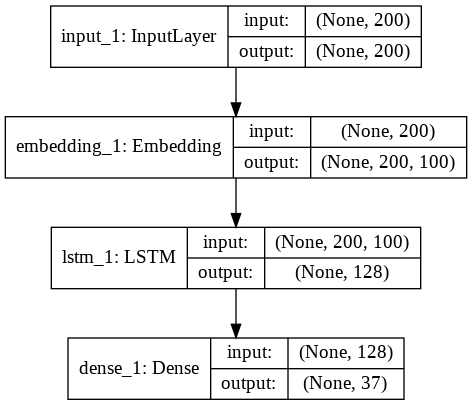

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# **Training**

In [15]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)



Train on 1953 samples, validate on 489 samples
Epoch 1/5
1953/1953 [==============================] - 7s 4ms/step - loss: 0.6052 - acc: 0.9220 - val_loss: 0.2752 - val_acc: 0.9348
Epoch 2/5
1953/1953 [==============================] - 6s 3ms/step - loss: 0.2112 - acc: 0.9429 - val_loss: 0.1809 - val_acc: 0.9463
Epoch 3/5
1953/1953 [==============================] - 6s 3ms/step - loss: 0.1813 - acc: 0.9445 - val_loss: 0.1730 - val_acc: 0.9463
Epoch 4/5
1953/1953 [==============================] - 6s 3ms/step - loss: 0.1770 - acc: 0.9445 - val_loss: 0.1727 - val_acc: 0.9463
Epoch 5/5
1953/1953 [==============================] - 6s 3ms/step - loss: 0.1766 - acc: 0.9445 - val_loss: 0.1720 - val_acc: 0.9463


# **Score**

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score/ F1 Score:", score[0])
print("Test Accuracy:", score[1])

611/611 [==============================] - 3s 5ms/step
Test Score/ F1 Score: 0.17891554729540493
Test Accuracy: 0.9444419911372096


# **Plotting**

See if it overfits or not?
Doesn't overfit

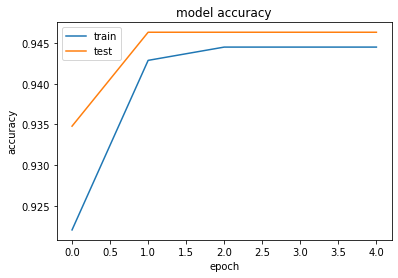

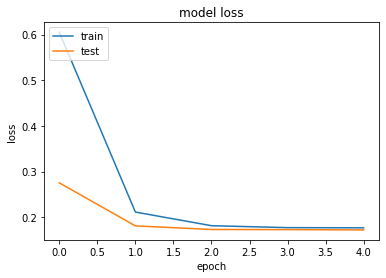

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()